In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv('/content/Retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1/12/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()

In [ ]:
lb.fit(df['StockCode'])
stock = lb.transform(df['StockCode'])
df['StockCode'] = stock
lb.fit(df['Description'])
des = lb.transform(df['Description'])
df['Description'] = des
#lb.fit(df['InvoiceDate'])
#date = lb.transform(df['InvoiceDate'])
#df['InvoiceDate'] = date
lb.fit(df['Country'])
cont = lb.transform(df['Country'])
df['Country'] = cont
#lb.fit(df['InvoiceNo'])
#no = lb.transform(df['InvoiceNo'])
#df['InvoiceNo'] = no
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,3536,3918,6,1/12/2010 8:26,2.55,17850.0,36
1,536365,2794,3926,6,1/12/2010 8:26,3.39,17850.0,36
2,536365,3044,913,8,1/12/2010 8:26,2.75,17850.0,36
3,536365,2985,1910,6,1/12/2010 8:26,3.39,17850.0,36
4,536365,2984,2911,6,1/12/2010 8:26,3.39,17850.0,36


In [ ]:
df = df[df['InvoiceNo'].notna()]

In [ ]:
# Sample the dataset
df_fix = df.sample(10000, random_state = 42)
# Convert to show date only
from datetime import datetime
df_fix['InvoiceDate'] = pd.to_datetime(df_fix['InvoiceDate'], errors='coerce')
df_fix["InvoiceDate"] = df_fix["InvoiceDate"].dt.date
# Create TotalSum colummn
df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["UnitPrice"]
# Create date variable that records recency
import datetime
snapshot_date = max(df_fix.InvoiceDate) + datetime.timedelta(days=1)
# Aggregate data by each customer
customers = df_fix.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})
# Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

In [ ]:
customers

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,96,5,81.60
12349.0,20,1,19.90
12353.0,206,1,39.80
12354.0,234,2,25.45
12356.0,327,1,50.00
...,...,...,...
18263.0,27,5,114.88
18270.0,268,2,68.50
18272.0,152,3,52.20


In [ ]:
#Избавляемся от уклона распределения данных
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
2428,5.421446,1.021167,4.861252
2429,13.543857,0.564199,4.091635
2430,11.027374,0.798349,3.737290
2431,10.973252,1.253008,3.013275
2432,12.261202,0.000000,2.482545


In [ ]:
# Import library
from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[-0. -0. -0.]
[1. 1. 1.]


In [ ]:
customers_normalized

array([[ 0.01186429,  1.21951748,  0.72395533],
       [-1.20185152, -1.06585057, -0.24058203],
       [ 0.82625656, -1.06585057,  0.17684952],
       ...,
       [ 0.48097534,  0.72085025,  0.36830141],
       [ 0.46659044,  1.73837665, -0.06078112],
       [ 0.80890909, -1.06585057, -0.37531394]])

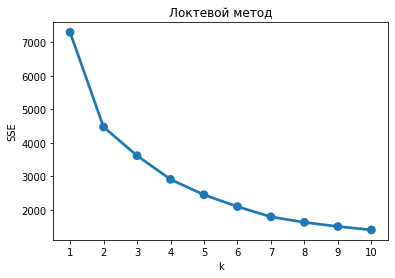

In [ ]:
import seaborn as sns
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('Локтевой метод')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(2433,)

In [ ]:
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0        241.19      1.47         24.07   983
1         48.36      1.48         15.79   640
2         67.11      6.29        140.81   810

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


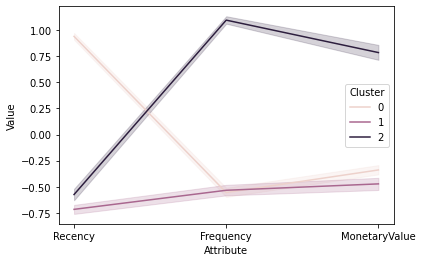

In [ ]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)